In [1]:
import copy
import math
from collections import namedtuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# 残差And标准化

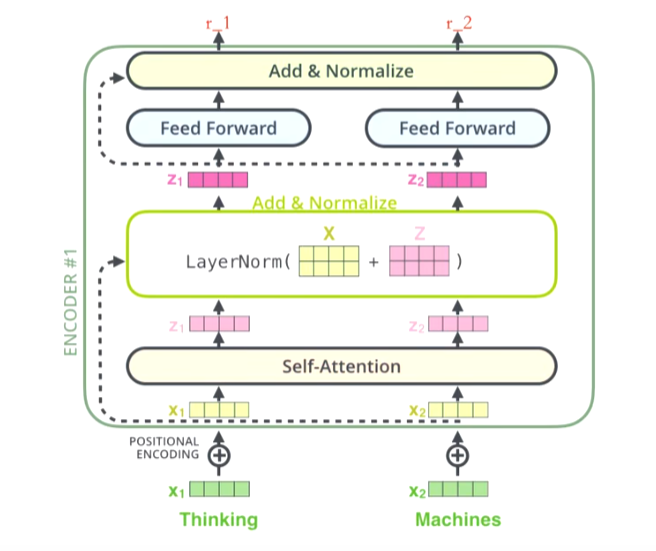
## 标准化公式
$$
y = \frac{x - E(x)}{\sqrt{Var(x)+e}}* \gamma + \beta
$$
- E(x) 对x求均值
- Var(x) 对x求方差
- e 是一个很小的数，防止分母为0
- $\gamma$ 和 $\beta$ 是可学习的参数

In [ ]:

class LayerNorm(nn.Module):
    def __init__(self, feature, eps=1e-6):
        """
        :param feature: self-attention 的 x 的大小
        :param eps:
        """
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(feature))
        self.b_2 = nn.Parameter(torch.zeros(feature))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        super(SublayerConnection, self).__init__()
        self.layer_norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    def forward(self,x, sublayer):
        return self.dropout(self.layer_norm(x + sublayer(x)))

#  多头注意力

注意力机制 = QKV相乘，QK相乘得到相似度 A， A和V相乘得到注意力值 Z
自注意力（QKV同源）
多头 = 8 

In [ ]:
def self_attention(query, key,value, dropout=None, mask=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        mask.cuda()
        scores = scores.masked_fill(mask == 0, -1e9)
    self_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        self_attn = dropout(self_attn)
    return torch.matmul(self_attn, value), self_attn

In [1]:
class MultiHeadAttention(nn.Module):
    def __init__(self, head, d_model, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert (d_model % head == 0)
        self.d_k = d_model // head
        self.head = head # 多头的数量 默认为8
        self.d_model = d_model # 输入的维度
        self.linear_query = nn.Linear(d_model, d_model)
        self.linear_key = nn.Linear(d_model, d_model)
        self.linear_value = nn.Linear(d_model, d_model)
        self.linear_out = nn.Linear(d_model,d_model)
        self.dropout = nn.Dropout(dropout)
        self.attn = None
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        n_batch = query.size(0)
        query = self.linear_query(query).view(n_batch,-1,self.head,self.d_k).transpose(1,2)
        key = self.linear_key(key).view(n_batch,-1,self.head,self.d_k).transpose(1,2)
        value = self.linear_value(value).view(n_batch,-1,self.head,self.d_k).transpose(1,2)
        
        x, self.attn = self.attention(query, key, value, dropout=self.dropout, mask=mask)
        x = x.transpose(1,2).contiguous().view(n_batch, -1,self.head * self.d_k)
        return self.linear_out(x)

SyntaxError: invalid syntax (2150004750.py, line 1)

# 位置编码

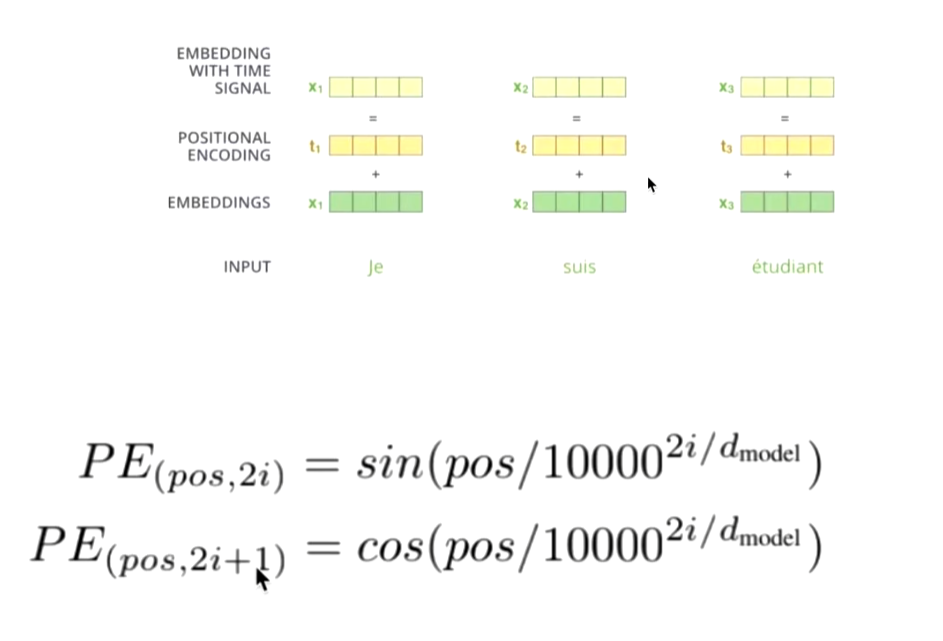

In [ ]:
class PositionsalEncoding(nn.Module):
    def __init__(self, dim, dropout, max_len=5000):
        super(PositionsalEncoding, self).__init__()
        if dim % 2 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with odd dim (got dim={:d})".format(dim))
        
        # 构建位置编码
        # PE(pos, 2i/2i+1) = sin/cos(pos/10000^(2i/d_{model}))
        pe = torch.zeros(max_len, dim) # max_len 是解码器生成句子的最长长度
        position = torch.arange(0,max_len).unsqueeze(1)
        div_term = torch.exp((torch.arange(0,dim,2,dtype=torch.float) * -(math.log(10000.0)/dim)))
        pe[:,0::2] = torch.sin(position.float() * div_term)
        pe[:,1::2] = torch.cos(position.float() * div_term)
        pe = pe.unsqueeze(1)
        super(PositionsalEncoding, self).__init__()
        self.register_buffer('pe', pe)
        self.drop_out = nn.Dropout(p=dropout)
        self.dim = dim
    def forward(self, emb, step=None):
        emb = emb * math.sqrt(self.dim)
        if step is None:
            emb = emb + self.pe[:emb.size(0)]
        else:
            emb = emb + self.pe[step]
        emb = self.drop_out(emb)
        return emb
    

# 前馈神经网络

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self,d_model,d_ff, dropout = 0.1):
        super(PositionWiseFeedForward,self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.layer_norm = nn.LayerNorm(d_model,eps = 1e-6)
        self.dropout_1 = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dropout_2 = nn.Dropout(dropout)
    def forward(self,x):
        inter = self.dropout_1(self.relu(self.w_1(self.layer_norm(x))))
        output = self.droput_2(self.w_2(inter))
        return output
        